# How 2 Fourier Transform

Si vous sentez le besoin d'un petit rappel sur la théorie mathématique derrière la transformée de Fourier (et même dans le cas contraire), allez regardez ce vidéo https://www.youtube.com/watch?v=spUNpyF58BY& 

Ce notebook présente les bases nécessaires à l'utilisation des transformés de Fourier numériques pour l'analyse et traitement de signaux et d'image avec python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## FFT d'un signal

Commençons par étudié comment utilisé les transformé de Fourier numérique (FFT for fast Fourier transform) sur des signaux. Ici, on utilise numpy pour générer le signal suivant

$$
y(t) = \sin(17\cdot t) + 0.3\sin(45\cdot t) + 0.1\sin(431\cdot t)
$$

composé des quatre fréquences [17, 45, 192, 431], toutes avec différentes amplitudes. Pour ce faire, ce signal continu (théorique) doit être échantilloné (sampled). L'échantillonnage (sampling) est un procédé complexe au coeur du traitement de signal dont seules les bases sont présentées ici.

Notre sampled signal (`s`) est composé d'un nombre (`nbins`) fini de valeurs ou *bins* (le terme *bin* est souvent utilisé en traitement de signaux pour faire référence à un interval discret).


### Échantillonage du signal

In [2]:
# Sampling parameters
L = 1 # signal's total duration [s] (tough the units dont really matter here)
nbins = 1000 # total number of bins used to sample the signal
sfreq = nbins/L # sampling frequency of the signal [Hz] (we'll need it later...)

# Signal 'xaxis' usually a time axis (t) or a space axis (x,y,z)
t = np.linspace(0, L, nbins)

# Signal parameters
fs = [17, 45, 431] # list of frequencies in our signal
amps = [1, 0.5, 0.2] # list of amplitudes (1 per frequency)

# generation of our signal
s = np.zeros(t.shape)
for f, amp in zip(fs, amps):
    s += amp*np.sin(2*np.pi*f*t) # be careful, things work in angular frequencies!!!

### Visualisation du signal

Text(0, 0.5, 'Signal (s)')

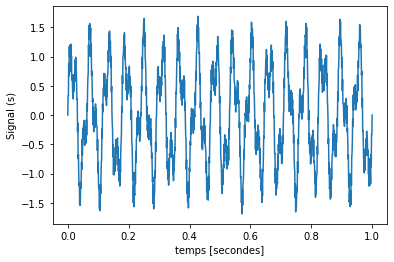

In [3]:
plt.plot(t, s)
plt.xlabel('temps [secondes]')
plt.ylabel('Signal (s)')

### Calcul de la FFT

La FFT (`S`) du notre signal (`s`) est facilement calculée avec la fonction fft() du module fft de numpy (`np.fft.fft()`). Notez que la FFT d'un signal fini est complexe et il faut appliquer quelques transformations à celle-ci afin de tracer le spectre de notre signal (FFT(s) $\neq$ Spectre(s)). En fait, la FFT(s) contient l'information du *spectre d'amplitude* ($S_{amp}$) ainsi que le *spectre de phase* ($S_{phase}$),

$$
FFT(s) = S_{amp}\cdot e^{iS_{phase}}
$$

De plus, la FFT doit être normalisée et être ajusté (scaled) entre $0$ et $f_{sampling}$.

Text(0.5, 0, 'Frequency bins')

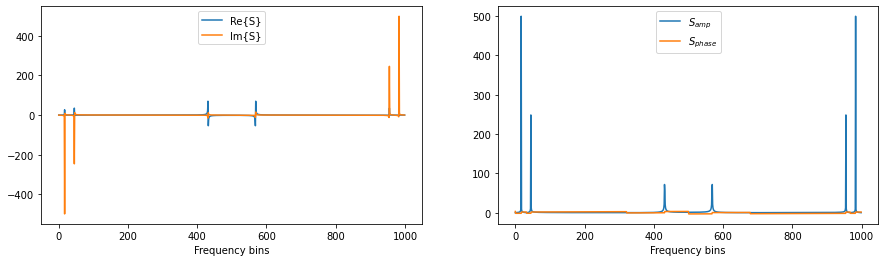

In [4]:
# Computing fft(s)
S = np.fft.fft(s)

plt.figure(figsize=[15, 4])
# Plotting real and imaginary parts of S
plt.subplot(1,2,1)
plt.plot(S.real, label='Re{S}')
plt.plot(S.imag, label='Im{S}')
plt.legend(loc='upper center')
plt.xlabel('Frequency bins')

# Plotting amplitude and phase of S
plt.subplot(1,2,2)
plt.plot(np.abs(S), label='$S_{amp}$')
plt.plot(np.angle(S), label='$S_{phase}$')
plt.legend(loc='upper center')
plt.xlabel('Frequency bins')

Maintenant, nous allons calculer le spectre d'amplitude de `s`

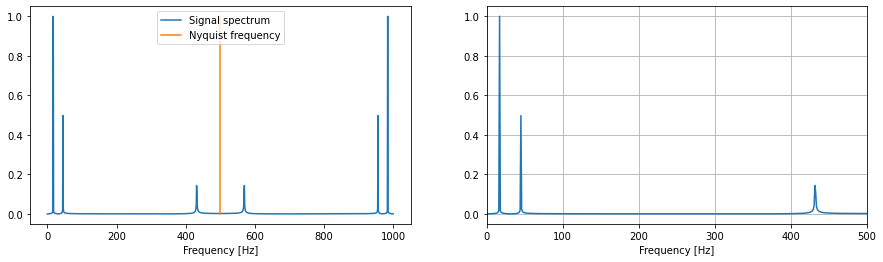

In [5]:
# Amplitude spectrum must be normalized as 2*|FFT(s)|/sfreq
S_amp = 2*np.abs(S)/sfreq

# Frequency axis
f = np.linspace(0, sfreq, nbins)

plt.figure(figsize=[15, 4])
# Plotting complete frequency range
plt.subplot(1,2,1)
plt.plot(f, S_amp, label='Signal spectrum')
plt.plot([sfreq/2, sfreq/2], [0, 1], label = 'Nyquist frequency')
plt.xlabel('Frequency [Hz]')
plt.legend(loc='upper center')

# Plotting 0 to f_nyquist
plt.subplot(1,2,2)
plt.plot(f, S_amp)
plt.xlabel('Frequency [Hz]')
plt.xlim([0, sfreq/2])
plt.grid()


Ici, on remarque quelque chose d'extrêmement important pour le traitement de signal: nous avons obtenu un spectre symétrique autour de 500 Hz. Ici, 500 Hz est la *fréquence de Nyquist* de notre signal (https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). La fréquence de Nyquist est la fréquence la plus grande qui peut être identifiée dans un signal discret (sampled). De plus, la fréquence de Nyquist correspond à $f_{sampling}/2$. En d'autres mots, il faut échantillon au moins à 2 x la fréquence la plus grande présente dans un signal. Pour cette raison, la visualization des spectres de signaux est généralement faite dans l'interval $f\in [0, f_{sampling}/2]$.

On peut maintenant identifier trois pics, un pour chaque fréquences présente dans notre signal. De plus, la hauteur de chaque pic correspond à la valeur d'amplitude de chaqu'une des ondes faisant partie du signal global.

$$
y(t) = \sin(17\cdot t) + 0.3\sin(45\cdot t) + 0.1\sin(431\cdot t)
$$

**NOTE** bien sûr, en pratique nous mesurons toujours un peu de bruit ce qui rend difficile/impossible d'identifier la fréquence de sampling idéale.

### Filtrage de signal

Maintenant que nous sommes experts en calcul de spectre de signal via la FFT, étudions comment construire et appliquer un filtre dans le domaine spectral. Comme exemple, nous allons retirer la fréquence 431 Hz de notre signal d'origine ($y_0$) via un filtre spectral et comparer le résultat avec le signal ($y_1$)

$$
y_0(t) = \sin(17\cdot t) + 0.3\sin(45\cdot t) + 0.1\sin(431\cdot t)
$$

$$
y_1(t) = \sin(17\cdot t) + 0.3\sin(45\cdot t)
$$

Pour ce faire, nous allons calculer une fenêtre (window) notée `W(f)` dans le domaine fréquentiel de sorte que

$$
S_1 = S_0\cdot w
$$

et nous allons ensuite calculer la transformée de Fourier inverse

$$
y_1' = iFFT{S_1}
$$

Nous allons construire $w$ pour un filtre passe-bas à fréquence de coupure $f_c=400$ Hz.

Prenez garde!!! Nous devons travailler avec $S_0$ et non le **spectre d'amplitude**. De plus, $w$ doit aussi être symétrique de chaque côté de la fréquence de Nyquist.

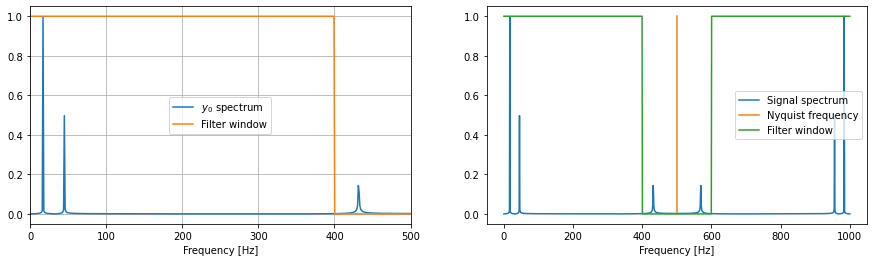

In [6]:
# Creation of window

w = 1*(f[:len(f)//2]<400) # This is the first half of the window
w=np.concatenate((w,w[::-1]))

# Visualization of window on y_0 amplitude spectrum

plt.figure(figsize=[15, 4])
# Plotting 0 to f_nyquist
plt.subplot(1,2,1)
plt.plot(f, S_amp, label='$y_0$ spectrum')
plt.plot(f, w, label='Filter window')
plt.xlabel('Frequency [Hz]')
plt.xlim([0, sfreq/2])
plt.grid()
plt.legend()

# Plotting complete frequency range
plt.subplot(1,2,2)
plt.plot(f, S_amp, label='Signal spectrum')
plt.plot([sfreq/2, sfreq/2], [0, 1], label = 'Nyquist frequency')
plt.plot(f, w, label='Filter window')
plt.xlabel('Frequency [Hz]')
plt.legend()

Text(0.5, 0, 'temps [secondes]')

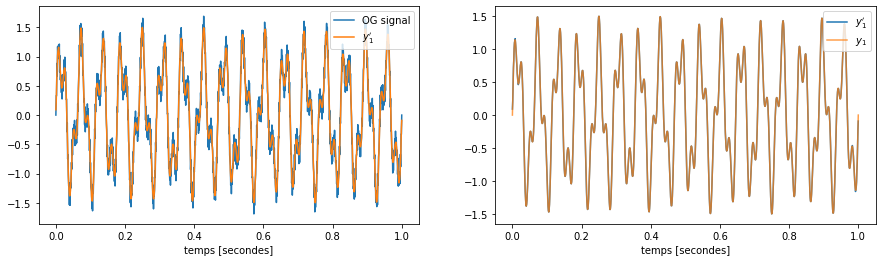

In [7]:
# Computing filtered spectrum (S_1)
S1 = S*w

# Computing y_1' via iFFT
y1 = np.fft.ifft(S1).real # we need to discard the imag part here

# Creation of y1_theo for comparaison
y1_theo = np.zeros(t.shape)
fs = [17, 45]
for f, amp in zip(fs, amps):
    y1_theo += amp*np.sin(2*np.pi*f*t) # be careful, things work in angular frequencies!!!
    
# Plotting results
plt.figure(figsize=[15,4])

# Comparing original and filtered signals
plt.subplot(1,2,1)
plt.plot(t, s, label='OG signal')
plt.plot(t, y1, label='$y_1\'$')
plt.legend()
plt.xlabel('temps [secondes]')

# Comparing filtered signals (y1) and theoretical target (y1_theo)
plt.subplot(1,2,2)
plt.plot(t, y1, label='$y_1\'$')
plt.plot(t, y1_theo, label='$y_1$', alpha=0.75)
plt.legend()
plt.xlabel('temps [secondes]')

En pratique, les fenêtres quarrées ne sont jamais utilisées puisqu'elles causent des artéfacts (lobes secondaires). La FT d'une onde quarrée est un sinus cardinal. À la place, une multitude d'autres de fenêtres ont été développés, chacune avec ses avantages et inconvénients (parmi les plus connues - https://numpy.org/doc/stable/reference/routines.window.html). Le choix exact du type de fenêtre et le design de filtre sont un art qui nécessite beaucoup de pratique et d'expérience.

## Filtrage d'image

Tout ce que nous avons couvert avec la FFT 1d pour les signaux s'applique maintenant avec la FFT2d pour les images en adaptant quelques concepts. Par exemple, plutôt que des fréquences temporelles [Hz], nous travaillons maintenant avec des fréquences spatiales [m$^{-1}$] ou [pixels$^{-1}$].

Commençons par un exemple bien connu avec la photo `marvin_clean.png`

Text(0, 0.5, 'y (i)')

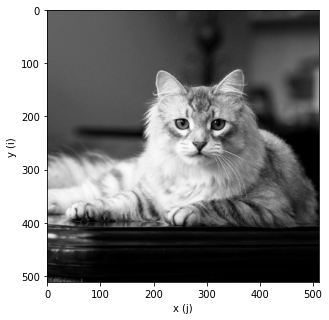

In [8]:
# Loading tiff image with matplotlib into a numpy array (requires Pillow)
marvin = plt.imread('data/marvin_clean.png')

plt.figure(figsize=[10, 5])
# Show color image
plt.imshow(marvin, cmap='gray')
plt.xlabel('x (j)')
plt.ylabel('y (i)')

Contrairement aux fft des signaux, les fft2 des images sont toujours shifté afin que la fréquence spatiale (0,0) se retrouve au milieu de l'image. De plus, il faut souvent plotter le log() de la fft2 pour voir quelque chose.

Text(0.5, 1.0, 'marvin 2d fft')

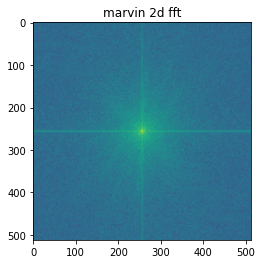

In [9]:
# Compute and shift fft2
Marvin = np.fft.fft2(marvin) # compute fft2
Marvin = np.fft.fftshift(Marvin) # shift fft2

# plot results
plt.imshow(np.log(np.abs(Marvin)))
plt.title('marvin 2d fft')

Voyons maintenant l'effet d'un filtre passe-bas sur une image. Comme pour le signal, utilisons une fenêtre quarrée (top-hat). En 2d, cette fenêtre correspond à un cylindre de rayon $f_c$. Essayons avec $f_c = 50\ pixels^{-1}$

Text(0.5, 1.0, 'Filtered marvin 2d fft')

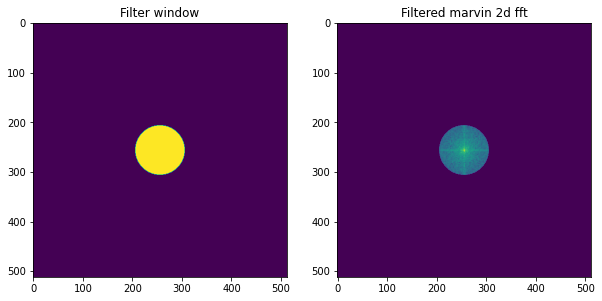

In [10]:
# Creation of window
w = np.ones(marvin.shape)
fc = 50
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        r2 = (i-511/2)**2 + (j-511/2)**2
        if r2 > fc**2:
            w[i,j] = 0

            
# Appliying filter on marvin 2d fft
Marvin_filtered = Marvin*w

# plot results
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(w)
plt.title('Filter window')

plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(Marvin))*w)
plt.title('Filtered marvin 2d fft')

Text(0, 0.5, 'y (i)')

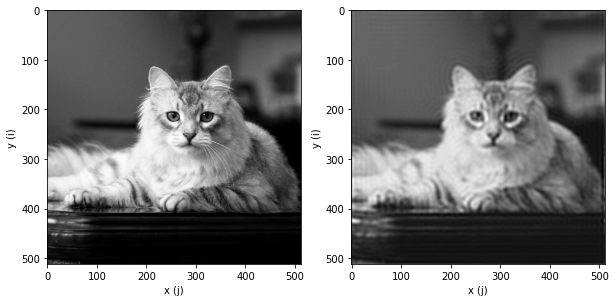

In [11]:
# Computing filtered marvin

Marvin_filtered_unshifted = np.fft.fftshift(Marvin_filtered) # we need to unshift
marvin_filtered = np.fft.ifft2(Marvin_filtered_unshifted).real

# Comparing OG marvin and filtered marvin

plt.figure(figsize=[10, 5])
# Show color image
plt.subplot(1,2,1)
plt.imshow(marvin, cmap='gray')
plt.xlabel('x (j)')
plt.ylabel('y (i)')

# Show greyscale image
plt.subplot(1,2,2)
plt.imshow(marvin_filtered, cmap='gray')
plt.xlabel('x (j)')
plt.ylabel('y (i)')